In [1]:
# Import necessary libraries for transcript retrieval
import pandas as pd
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter

In [2]:
# Import necessary libraries for text pre_processing
import re
import spacy
import nltk
import wordninja
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

In [3]:
# Import necessary libraries for generating text chunks, embeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings

In [4]:
# Import necessary libraries for summarization
from transformers import pipeline
from langchain import HuggingFacePipeline
from langchain import PromptTemplate,  LLMChain

In [5]:
# Import necessary libraries for evaluation
from rouge import Rouge

##### Retrieving Transcript
The function 'youtube_transcript' will perform subtitle extraction from YouTube videos corresponding to the given video id. And the transcript is then formatted using 'TextFormatter'. The function will return the formatted transcript

In [6]:
# Function for retrieving transcripts
def youtube_transcript(video_id):
    # Retrieving the transcripts
    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    
    # Initializing the text formatter and formatting the transcript
    formatter = TextFormatter()
    transcript_formatted = formatter.format_transcript(transcript)
    
    return transcript_formatted

##### Pre-processing
Pre-processing is needed for the transcript. The function 'text_preprocessing' will perform the following preproccesings for the video transcripts:
1. Removing special characters 
2. Splitting concatenated words
3. Converting the text from upper case to lower case
4. Lemmatization
5. Spelling correction

In [7]:
# Function for text preprocessing
def text_preprocessing(transcript):
    # Removing special characters including newline character '\n'
    transcript = re.sub(r'[,\.!?<>/]', '', transcript)
    
    # Splitting concatenated words
    transcript_cleaned = ' '.join(wordninja.split(transcript))
    
    # Converting the text to lower case
    transcript_cleaned = transcript_cleaned.lower()
    
    # Text lemmatization (Spacy)
    # Initialise spacy 'en' model
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    temp_transcript = nlp(transcript_cleaned)
    transcript_lemmatized = ' '.join([token.lemma_ for token in temp_transcript])
    
    # Spelling correction using TextBlob
    transcript_pre_processed = str(TextBlob(transcript_lemmatized).correct())
    
    return transcript_pre_processed

##### Chunk of Text
To make the text easily processed, the raw text is transformed into chunks through breaking the text into smaller segments. Chunk overlap mechanism is employed to maintain the coherence between chunks.

The text splitter for generic text is the LangChain RecursiveCharacterTextSplitter. It has a list of characters as its parameter. 
The list is ["\n", "\n", " ", ""] by default.

In [8]:
# Function for chunk of text
def text_chunk(processed_transcript):
    # Creating an instance of RecursiveCharacterTextSplitter
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2500, 
                                                   chunk_overlap=300, 
                                                   length_function=len)
    
    # Splitting the processed transcript into chunks
    chunks = text_splitter.split_text(processed_transcript)
    
    return chunks

#### SUMMARIZATION

##### Generating the summary
The function will iterate through each chunk and generate summary using llm_chain. The generated summaries will append to a list.

In [10]:
# Function for generating the summary
def generating_summary(chunks_transcript, llm):
    
    # Defining the template for prompting
    template = """
           Please summarize the following text:
           
           ```
           {text}
           ```
           
           """
    
    # Creating the PromptTemplate object
    prompt = PromptTemplate(template=template, input_variables=["text"])

    # Creating the LLMChain object
    # LLMChain is for chaining tasks
    llm_chain = LLMChain(prompt=prompt, llm=llm)
    
    summaries = []
    for chunk in chunks_transcript:
        summary = llm_chain.run(text=chunk)
        summaries.append(summary)
    
    summarized_text = ' '.join(summaries)
    
    return summarized_text

##### Summarizer Evalution
The summary generated by the model is evaluated againts a reference summary based on ROUGE score. Value close to 1 shows best performance. 

In [11]:
def rouge_evaluation(generated_summary, reference_summary):
    
    # ROUGE Initilization
    rouge = Rouge()
    
    # score calculation by comparing generated_summary to reference_summary
    score =  rouge.get_scores(generated_summary, reference_summary, avg=True)
    
    return score

In [13]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=0_C1EjY3Yig'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)


In [14]:
# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
# Initializing the summarization pipeline
# Model loading (facebook/bart-large-cnn)
summarization_pipeline = pipeline("summarization", 
                                  model="facebook/bart-large-cnn", 
                                  max_length=100,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)


# Generating the summary for transcripts
transcript_summary_1 = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [15]:
transcript_summary_1

"In today 's video I be go to give you the step by step guide for build a house why because in my 15 plus year of sell nearly 500 new construction home I find that a lot of people become frustrated because they do not understand the home build process. If you have question about buy selling or build a home in utah I would love to talk with you please feel free to type a message below or you be welcome to contact I directly. The excavation will mark the home site so they know where to dig like you see here behind I step number two they will break ground dig the hole for the house in this case the hole be pretty deep because this home will have a basement step number three they will pour the concrete footing. The process of building a home begins with back fill or pushing the dirt back in around the foundation wall and they will compact the soil. The four way process begins as several different trade begin work on the home at this time. The home will receive an inspection from the city t

In [84]:
summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=100,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary_2 = generating_summary(chunks_transcript, llm)

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


In [17]:
transcript_summary_2

"The text provides a step-by-step guide on how to build a house in Utah. It emphasizes that the home build process can vary by week and even month depending on the builder's delay, but the guide will be accurate. The excavation will mark the final step. The text provides step-by-step instructions for building a house, including the excavation, breaking ground, pouring concrete, footing, foundation wall, window well, damp proof tar, and gas line. It also mentions that each builder has their own timing and trade might be delayed. The text provides instructions on how to complete a home's framing process, including backfilling or pushing dirt around the foundation wall, pulling the concrete basement floor and garage floor, running the gas line from the street up to the house, installing the main electrical panel on the exterior, and completing the four-way process. The home will receive an inspection from the city to confirm that the work has been done to code number 17, the induration wi

##### SUMMARIZER EVALUTION (ROUGE)
Parameters :
* Chunk_size = 1500
* Chunk_overlap = 300
* pipeline(... max_length = 100, min_length = 25)

Ref. Summary :
* GPT-3.5


In [24]:
reference_summary = "The video by Ty, the Real Estate Guy, provides a comprehensive, step-by-step guide to building a house, drawing from his 15+ years of experience selling new construction homes. He emphasizes understanding the home-building process to avoid frustration and offers tips for each stage, from excavation to final walk-through and closing. Key steps include marking the site, pouring concrete, framing, installing utilities, and conducting inspections. Ty also advises on dealing with delays and variations in the building process. Additionally, he discusses the benefits of buying a spec home and offers links to other useful videos and resources for those interested in building, buying, or selling homes in Utah."

In [31]:
generated_summaries_1 = transcript_summary_1
generated_summaries_2 = transcript_summary_2


rouge_scores_1 = rouge_evaluation(generated_summaries_1, reference_summary)
rouge_scores_2 = rouge_evaluation(generated_summaries_2, reference_summary)

print("ROUGE Scores (facebook/bart-large-cnn) : \n", rouge_scores_1)
print("\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_scores_2)

ROUGE Scores (facebook/bart-large-cnn) : 
 {'rouge-1': {'r': 0.3132530120481928, 'p': 0.10358565737051793, 'f': 0.155688619019506}, 'rouge-2': {'r': 0.0380952380952381, 'p': 0.007797270955165692, 'f': 0.012944980998052582}, 'rouge-l': {'r': 0.27710843373493976, 'p': 0.09163346613545817, 'f': 0.13772454716321858}}


ROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): 
 {'rouge-1': {'r': 0.4578313253012048, 'p': 0.15966386554621848, 'f': 0.23676012077639}, 'rouge-2': {'r': 0.12380952380952381, 'p': 0.030303030303030304, 'f': 0.04868913541745592}, 'rouge-l': {'r': 0.42168674698795183, 'p': 0.14705882352941177, 'f': 0.2180685319913433}}


Based on the ROUGE score, the performance of MBZUAI/LaMini-Flan-T5-248M is better than facebook/bart-large-cnn. 

##### Tuning Parameters and Summary Evaluation (MBZUAI/LaMini-Flan-T5-248M )

In [110]:
# Importing the summarization pipeline
summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=100,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

* chunk_size = 2000

In [38]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah. It explains that the process can vary by week and even month depending on the builder's timing, but the guide will be accurate. It also mentions that the concrete needs about 10 days to cure or garden before starting the frame, but there are a lot that can be done while waiting. The text describes the process of building a house, including pouring concrete, footing, foundation, wall, water line, window well, excavation, and electrical panel installation. It also mentions that the frame will vary depending on the size of the house and the number of frame assigns to the home. The building will receive an inspection from the city to confirm that the work has been done to code number 17, and the induration will be hang. The builder will schedule  The text provides instructions on how to install a home's exterior, including the installation of code number 17, the induration, and a meeting with the builder before the ins

* chunk_size = 2000
* chunk_overlap = 400

In [45]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah. It explains that the process can vary by week and even month depending on the builder's timing, but the guide will be accurate. It also mentions that the concrete needs about 10 days to cure or garden before starting the frame, but there are a lot that can be done while waiting. The text provides instructions on how to build a house, including digging a hole deep, pouring concrete, footing, foundation wall, and framing. It also mentions that the process will vary depending on the size of the house and the number of frame assigns to the home. The home will receive an inspection from the city to confirm that the work has been done to code number 17, and the induration will be hang. The text provides instructions on how to complete work on a home, including installing electrical, plumbing, and HVAC systems. The home will receive an inspection from the city to confirm code number 17, the installation of drywall, a dash

* Chunk_size = 1200
* Chunk_overlap = 400


In [67]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah. The author explains that the home build process can vary by week and even month depending on the builder's delay, weather, or shortage in labor material. They also mention that not everything in the process needs to be in a specific order, such as the exterior of the home starting week later. The text reminds readers that the home build process can vary by week and even month depending on the builder's delay, weather, or shortage in labor material. It also emphasizes that not everything in the process needs to be in a specific order and that each builder has their own timing. The text also mentions that the concrete needs about 10 days to cure or garden before starting the frame, but there are a lot that can be done while waiting. The text provides instructions on how to build a house, including digging a hole deep, pouring concrete, footing, and foundation, waiting for a 10 day to cure or garden, running sub-rough

* Chunk_size = 1700
* Chunk_overlap = 300


In [77]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah. It explains that the process can vary by week and even month depending on the builder's timing, but the guide will be accurate. The excavation will mark the home site and dig the hole for the house. The text provides step-by-step instructions on how to build a house, including the excavation, digging, pouring concrete, footing, foundation, water line, window well, damp proof tar, and framing. It also mentions that the frame will vary depending on the size of the house and the number of frame assigns to the home. The text provides instructions on how to complete an average-sized house in 10-14 days, including the installation of the main electrical panel, the four-way process, the inspection of code number 17, the induration, and the finish worker installing the dashboard, door case, and shelling. The text provides instructions on how to complete a home renovation project, including the installation of sheet rock, d

* Chunk_size = 2500
* Chunk_overlap = 300

In [99]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, damp proof tar, and excavation. It emphasizes that the process can vary by week and even month depending on the builder's timing and trade. The text provides instructions on how to build a house, including the placement of water, soil, excavation, gas line, framing, electrical panel installation, drywall installation, dashboard installation, door case installation, and painting. The text provides instructions on how to complete a home renovation project, including installing shelling, painting exterior doors and windows, laying a driveway, installing a large garage door, adding a final or tile floor, installing windows and cabinets, installing plumbing, and finishing the final touch-up and repair. It also mentions that the builder's representative will show how to work the home, and the final walk-through for the buyer will be scheduled. The 

* Chunk_size = 2200
* Chunk_overlap = 350

In [111]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, and damp proof tar. The process can vary by week and even month depending on the builder's timing, but the guide is accurate. The text provides instructions on how to start the framing process of a house, including the number of days to cure or garden, the amount of water lines running underneath the foundation wall, the window well being bolted around the basement window, the excavation backfilling or pushing dirt back in around the foundation walls, and the completion of the four-way process. It also mentions that the frame will vary depending on the size of the house, and that the work will be The text provides instructions on how to install a home's exterior, including the installation of various items such as the tub and shower surround, sheet rock, mud tape, and shelling. It also mentions different trades and the order of the work being

Configuration 6 (Chunk Size: 2500, Chunk Overlap: 300) provides the highest ROUGE-1 F1-score and competitive ROUGE-2 and ROUGE-L scores, lets' continue with configuration 6 (Chunk Size: 2500, Chunk Overlap: 300).

In [45]:
summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


* max_length = 150

In [18]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, and damp proof tar. The process can vary by week and even month depending on the builder's timing, but the guide is accurate. The text provides instructions on how to start the framing process of a house, including the number of days to cure or garden, the amount of water lines running underneath the foundation wall, the window well being bolted around the basement window, the excavation backfilling or pushing dirt back in around the foundation walls, and the completion of the four-way process. It also mentions that the frame will vary depending on the size of the house, and that the construction process will take 10-14 days. The builder will schedule a meeting with the builder to confirm that the work has been done to code number 17, and the induration will be hang. The text ends with a request for a thumb- The text provides instructions on 

* max_length = 125

In [20]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, and damp proof tar. The process can vary by week and even month depending on the builder's timing, but the guide is accurate. The text provides instructions on how to start the framing process of a house, including the number of days to cure or garden, the amount of water lines running underneath the foundation wall, the window well being bolted around the basement window, the excavation backfilling or pushing dirt back in around the foundation walls, and the completion of the four-way process. It also mentions that the frame will vary depending on the size of the house, and that the construction process will take 10-14 days. The builder will schedule a meeting with the builder to confirm that the work has been done The text provides instructions on how to install a home's exterior, including the installation of various items such as the tub 

* max_length = 80

In [22]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, and damp proof tar. The process can vary by week and even month depending on the builder's timing, but the guide is accurate. The text provides instructions on how to start the framing process of a house, including the number of days to cure or garden, the amount of water lines running underneath the foundation wall, the window well being bolted around the basement window, the excavation backfilling or pushing dirt around the foundation walls, and the completion of the four-way process. It also mentions that The text provides instructions on how to install a home's exterior, including the installation of various items such as the tub and shower surround, sheet rock, mud tape, and shelling. It also mentions different trades and the order of the work being completed. The text provides instructions on how to build a home, including the final H s

* max_length = 95

In [30]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, and damp proof tar. The process can vary by week and even month depending on the builder's timing, but the guide is accurate. The text provides instructions on how to start the framing process of a house, including the number of days to cure or garden, the amount of water lines running underneath the foundation wall, the window well being bolted around the basement window, the excavation backfilling or pushing dirt back in around the foundation walls, and the completion of the four-way process. It also mentions that the frame will vary depending on the size of the house and the The text provides instructions on how to install a home's exterior, including the installation of various items such as the tub and shower surround, sheet rock, mud tape, and shelling. It also mentions different trades and the order of the work being completed. The tex

* chunk_size = 2500
* chunk_overlap = 300
* max_length = 80

In [39]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, damp proof tar, and excavation. It emphasizes that the process can vary by week and even month depending on the builder's timing and trade. The text provides instructions on how to build a house, including the placement of water, soil, excavation, gas line, framing, electrical panel installation, drywall installation, dashboard installation, door case installation, and painting. The text provides instructions on how to complete a home renovation project, including installing shelling, painting exterior doors and windows, laying a driveway, installing a large garage door, adding a final or tile floor, installing windows and cabinets, installing plumbing, and finishing the final touch-up and repair. It also mentions that the final walk-through for the buyer is scheduled The text discusses the home build process, including final items 39, final 

###### Parameters : 
* chunk_size = 2500
* chunk_overlap = 300
* max_length = 80
###### Ref. Summary : 
* Gemini

In [41]:
reference_summary = "This YouTube video offers a comprehensive guide on building a house, acknowledging that the specific order may vary by builder. The walkthrough starts with prepping the land, including excavation, foundation pouring, and installing plumbing and electrical lines.  Then comes framing the house, followed by inspections.  Next, crews tackle the interior and exterior simultaneously, installing tubs, showers, drywall, windows, and siding.  As the interior nears completion with cabinets, doors, and paint,  exterior work on decks and driveways commences.  The final stretch involves light fixtures, appliances, flooring, and touch-ups.  After a final walkthrough by you and the builder, you're ready to close on the house and receive the keys!  The video also mentions time-saving options with pre-built houses offered by some builders."

In [42]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, damp proof tar, and excavation. It emphasizes that the process can vary by week and even month depending on the builder's timing and trade. The text provides instructions on how to build a house, including the placement of water, soil, excavation, gas line, framing, electrical panel installation, drywall installation, dashboard installation, door case installation, and painting. The text provides instructions on how to complete a home renovation project, including installing shelling, painting exterior doors and windows, laying a driveway, installing a large garage door, adding a final or tile floor, installing windows and cabinets, installing plumbing, and finishing the final touch-up and repair. It also mentions that the final walk-through for the buyer is scheduled The text discusses the home build process, including final items 39, final 

###### Parameters : 
* chunk_size = 2500
* chunk_overlap = 300
* max_length = 80
###### Ref. Summary : 
* GPT-4o

In [46]:
reference_summary = 'In this video, Ty the Real Estate Guy provides a step-by-step guide on building a house, drawing from his 15+ years of experience selling nearly 500 new construction homes. He outlines the entire home building process, starting with excavation and ending with closing on the home. Ty emphasizes that the process can vary depending on the builder, weather, and material or labor shortages.The key steps include marking the home site and breaking ground, pouring the concrete footing and foundation walls, running utility lines and damp-proofing the foundation, framing the house and installing main electrical panels, conducting city inspections, and installing insulation. This is followed by completing interior and exterior work, including painting, flooring, cabinets, and final installations. Finally, quality and homeowner walkthroughs are conducted to ensure everything is in order before closing on the home.Ty encourages viewers to ask questions, subscribe to his channel, and watch related videos for more detailed guidance. He also mentions the availability of spec homes, which can expedite the building process. For those interested in moving to Utah or needing real estate services, he invites direct contact.'

In [50]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides a step-by-step guide on how to build a house in Utah, including the excavation, concrete footing, foundation wall, window well, damp proof tar, and excavation. It emphasizes that the process can vary by week and even month depending on the builder's timing and trade. The text provides instructions on how to build a house, including the placement of water, soil, excavation, gas line, framing, electrical panel installation, drywall installation, dashboard installation, door case installation, and painting. The text provides instructions on how to complete a home renovation project, including installing shelling, painting exterior doors and windows, laying a driveway, installing a large garage door, adding a final or tile floor, installing windows and cabinets, installing plumbing, and finishing the final touch-up and repair. It also mentions that the final walk-through for the buyer is scheduled The text discusses the home build process, including final items 39, final 

#### YouTube videos of different duration

* https://www.youtube.com/watch?v=oBpN4p3SYgc : Duration 22:40

In [13]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=oBpN4p3SYgc'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

In [31]:
# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


In [34]:
reference_summary = "Before signing a contract with a new builder, it's crucial to understand the unique process of buying a new construction home, which differs significantly from purchasing a resale home. First, hire a real estate professional, as their services are free and they can guide you through the process, ensuring you get the best deal. Your agent should accompany you on your first visit to the builder to secure your representation. After touring model homes and selecting a floor plan, ask the builder about the price, lot premium, and available spec homes. Consider your timeline and current living situation when making decisions. Additionally, inquire about builder incentives, such as discounts, upgrades, or closing cost assistance, and ensure your agent reviews the purchase agreement and any potential changes before you sign. Lastly, be aware of potential delays and attend walkthroughs to ensure all specifications and upgrades are correctly implemented."

In [35]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

Before signing a contract with a new builder, it is important to watch a video for a breakdown of the buying process and to be protected when purchasing your new home. It is also important to be aware of the timeline and the importance of hiring a professional real estate agent to represent you and negotiate the good deal for you. Additionally, having a reactor with you on The text discusses how to hire a buyer agent for a new construction home and how to ensure a positive relationship with the builder. It also mentions questions to ask the buyer agent about the price, lot premium, and timeline for building the new home. Finally, the speaker expresses a desire to receive a discount after confirming the purchase price. The text discusses how to negotiate a builder incentive for a new home, including negotiating a total of six percent towards the closing cost and additional overflow towards the buy down. It also mentions experience with builder offer, floor upgrade, appliance package, an

* https://www.youtube.com/watch?v=f_TwBOTp_no : Duration 11:09

In [36]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=f_TwBOTp_no'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)


summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors


In [38]:
reference_summary = "In this video, Nice Dark guides viewers through the 10 steps of buying a new construction home, using the setting of a new construction to enhance the tutorial. The first step is getting pre-approved for a home loan, advising buyers to shop around for the best mortgage terms rather than settling for the builder's preferred lender. Dark highlights the importance of securing a floating rate option to potentially benefit from lower interest rates during the construction period. Next, hiring a realtor is crucial, as the builder's agents typically represent the builder's interests. Realtors can help navigate the process and may know of suitable communities or developments. Once pre-approved and with a realtor, the house hunting begins. Buyers should ask about the expected timeline for completion and be aware that model homes often include upgrades that may not be present in the base models. When making an offer, it's typically at the advertised price, but buyers should be prepared to put down earnest money. The purchase may involve both a state contract and a builder-specific contract. Home inspections are essential, even for new constructions, as no home is perfect, and issues can arise that need addressing before closing. Dark advises against frequent visits to the construction site to avoid becoming a nuisance. A final punch list should be created to ensure all repairs and touch-ups are completed. Buyers should schedule the appraisal and secure home insurance, noting that new construction often results in lower premiums. The final walkthrough ensures all items on the punch list are addressed, leading up to the closing, where documents are signed and final payments made. Dark encourages viewers to reach out with any questions and offers assistance in connecting with a specialized agent."

In [39]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses how to buy a new construction home, including getting preapproved for a home loan, comparing loan types and lenders, and asking for an extension on interest rates. It also mentions an insider secret that lenders may not allow you to lock in a lower interest rate while under contract. The text provides tips on how to secure a low interest rate while under contract, such as looking into a rate float and hiring a reactor to represent you. It also emphasizes the importance of working with a buyer's agent and the possibility of an upgrade home with an accent wall, upgrade lighting package, or even a model home. The text discusses the desire of the builder to sell a home and the lifestyle of their community, including upgrades, accent walls, lighting packages, and landscaping. The next step is to make an offer, which may be different than when buying a house. The builder may expect you to put a certain dollar amount down as earnest money, and the next step should be The te

* https://www.youtube.com/watch?v=xKg4tdkEzc4 Duration : 29:49

In [40]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=xKg4tdkEzc4'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


In [42]:
reference_summary = "Buying your first home is an exciting yet intimidating experience as it is likely the largest financial purchase you'll ever make. To simplify the process, here are ten essential steps drawn from personal experience helping hundreds of homebuyers. First, plan your finances by focusing on savings, income, and credit score. Save enough to cover a down payment (usually 3.5% for FHA loans) and closing costs (around 3%). Ensure you have a stable income and aim for a credit score of at least 620, ideally 740, for better loan options. Second, hire a realtor to represent your interests; they can guide you through negotiations and often come at no cost to you. Third, get pre-approved for a loan, comparing rates and terms from various lenders. Fourth, start house hunting with a clear list of needs versus wants. Fifth, make an offer on a suitable house quickly to avoid losing it to other buyers. Sixth, conduct a thorough inspection during your due diligence period, including any specialized tests and securing home insurance. Seventh, negotiate any necessary repairs based on the inspection report. Eighth, handle the appraisal, ensuring the home’s value aligns with your contract price and addressing any required repairs. Ninth, perform a final walkthrough to verify the home’s condition and completed repairs. Finally, prepare for closing, where you’ll finalize your purchase and move into your new home."

In [43]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the 10 essential steps of buying a home, including saving money, saving income, and credit score, and avoiding down payment assistance programs. It also emphasizes the importance of saving up about 6 and a half to 7 total of the purchase price or the home amount to cover the down payment and closing cost, which is the responsibility of the buyer. The text discusses the importance of saving up 6 and a half to 7 total of the purchase price or home amount to cover the down payment and closing cost as a buyer. It emphasizes that closing costs are the responsibility of the buyer, and it is important to show that you have a good work history for at least two years. The text also emphasizes the need for  To start the home buying process financially, it is important to hire a buyer's agent to represent you and your purchase alone, but it may not always be the case. Buyers may be held liable for their agent's commission, so it's important to have a conversation with the agent

* https://www.youtube.com/watch?v=984lg7Ax2jE Duration 3:38

In [44]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=984lg7Ax2jE'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [46]:
reference_summary = "Purchasing a new home is an exciting process with many moving parts, especially when it comes to home building. With over 70 years of experience in constructing quality homes, we are here to guide you through the entire process. The five main steps to building a new home include selecting your community, floor plan, and home style, determining financing options, making design choices, and navigating the construction and closing process. Our sales consultants will help you choose the right fit for your preferences, while our affiliated mortgage experts can assist with financing questions. Once you finalize your choices, a home purchase agreement is prepared, and you will submit a loan application or provide proof of funds. You will then select design options for your home’s interior, which will be reflected in an updated purchase agreement. The construction phase begins with an introduction to your construction manager, who will keep you informed throughout the building process. After construction, closing involves signing documents to transfer ownership and move into your new home, which comes with an industry-leading warranty. Our customer care manager will handle any warranty requests, and our online resources offer additional information on maintaining your home. We aim to simplify the home building process so you can enjoy the excitement of purchasing a new home."

In [47]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides instructions on how to purchase a new home, including selecting a floor plan, choosing a structural option, generating a home purchase agreement, initiating the financing process, choosing design options, and completing the transfer of ownership. It also mentions the build quality experience and the necessary purchase fund. A construction professional will keep you informed throughout the process of bringing your home design to life, including closing, transfer of ownership, purchase fund delivery, industry lead warranty, customer care manager, online video, and more. They will help simplify the process for you to enjoy the excitement of purchasing a new home. 

ROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): 
 {'rouge-1': {'r': 0.2846715328467153, 'p': 0.5492957746478874, 'f': 0.3749999955034209}, 'rouge-2': {'r': 0.0975609756097561, 'p': 0.20618556701030927, 'f': 0.13245032676527357}, 'rouge-l': {'r': 0.23357664233576642, 'p': 0.4507042253521127, 'f': 0.3076923031957286}

* https://www.youtube.com/watch?v=NxC3qT7wc2M Duration : 18:51

In [48]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=NxC3qT7wc2M'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [52]:
reference_summary = "Buying a new construction home can be an exciting experience, especially for first-time homebuyers, but there are several important considerations to be aware of. First, it costs nothing to hire an experienced buyer's agent who can negotiate the best deal, inquire about incentives, and ensure you get the most value for your purchase. Understanding timelines and potential delays is crucial, as builders often provide estimated closing times, but delays due to weather, supply, or labor shortages are common. Buyers should be prepared for potential temporary housing needs. Hidden costs are another factor; the base price often excludes additional costs such as lot premiums, structural upgrades, and design upgrades, so it’s essential to budget for these extras to avoid surprises. Negotiation is key, and a buyer's agent can negotiate the base price, lot premiums, and design credits, particularly with spec homes, which are already built without a specific buyer in mind. Additionally, builders may offer incentives like closing cost assistance and interest rate buy-downs, which can significantly reduce out-of-pocket expenses. It’s also important to be aware of Special Improvement District (SID) and Local Improvement District (LID) fees, which are additional taxes for infrastructure and amenities. These fees can be substantial but transfer to the new buyer if you sell the home. Hiring a third-party inspection company ensures the home is built to code and identifies any issues that need addressing before closing. Determining your budget for design upgrades before visiting the design center is essential to avoid overspending on attractive finishes and upgrades. Finally, researching the surrounding area, amenities, schools, and future development plans is vital to ensure the community meets your long-term needs and can positively impact your home’s value. These insights help buyers navigate the complexities of purchasing a new construction home, ensuring a smoother and more informed experience."

In [53]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the experience of buying a new construction home as a first-time home buyer and the importance of hiring a buyer's agent to negotiate a good deal. It also mentions the timeline and potential delay during the anaemic. The speaker mentions a specific example of a time frame or delay during a construction home purchase. The text discusses the time frame and construction delay during the anaemic due to material shortages and the need to find alternative temporary housing to compensate for the delay. It also mentions hidden costs when purchasing a new construction home, such as lot premium, add-on top, and community engagement. The text discusses different types of structural upgrades that can be added to a new construction home, including adding a next gen suite or converting a left into an additional bedroom. The buyer needs to understand what they want to make to suit their lifestyle and family's lifestyle design upgrade. The sales consultant will schedule an appointme

* https://www.youtube.com/watch?v=VGNhqczdEM4 Duration 26:36

In [56]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=VGNhqczdEM4'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


In [71]:
reference_summary = """
Matt, a try manager for Ireland, explains how to assemble a complete roofing system, emphasizing the importance of understanding roof shapes and terminology. He details the components and installation steps, starting with a basic gable-to-gable roof. Key parts include the verge (roof edge), ridge (roof top), and rafters (primary timber). Roof pitch affects material choice, and tools like tape measures, chalk lines, hammers, and drills are essential. The process begins with installing a low-level ventilator to prevent condensation, followed by an underlay support tray to keep debris out while allowing airflow. The underlay used, "Superteach 402," is strong and suitable for any tile and pitch, preventing issues like "underlay ballooning." Proper spacing ensures water flows beneath the battens. The ridge system involves cutting the underlay back 30mm from the apex for airflow. Matt installs "Landmarks Double Roman" tiles with correct fixing points and spacing to avoid failure, using a dry-fix verge system for protection. The ridge system includes a breathable ridge roll and ridge tiles secured with seals and clamps. This guide, covering essential tools, materials, and techniques, ensures a secure and functional roof, with further details available in Ireland's self-build course.
"""

In [72]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides instructions on how to put together a merit-looking roof system. It emphasizes the importance of understanding the basic shape, details, and terminology involved in the roof. It also mentions the need for a low level ventilator to guide air up into the left cavity and prevent condensation. The text provides instructions on how to install a low level ventilator system on a roof using a 60 mild system. The system needs to come out above any pre-installed induration to block the air flow and cause condensation in the left area. The second part of the system is a purpose make tray with an integrate rifle underneath to allow air to flow up and The text provides instructions on how to install a roof underlip system using a 60 mild tack, a local fix for air underlip, and a baton. The purpose of the system is to prevent damage to the roof by preventing the wind load from getting on to the underlip. The text provides instructions on how to fix a barge board on a roof using a s

* https://www.youtube.com/watch?v=v3V7gb03y_g Duration : 37:34

In [17]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=v3V7gb03y_g'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [21]:
processed_transcript

"good morning everyone and thank you for dealing in to today 's web in ar my name be lucy quick and I be the digital marketing manager here at into track I be delighted to be join by steve johnson national key account manager at cos property insight he will be take morning morning lucy morning steve thank you very much for join we today so before I hand you over to steve I would like to draw your attention to the q a tax which be locate at the bottom of your screen we will be run a q a at the end of this session so please type any question you might have for steve along with your name into the q a box that way if we run out of time or your question require further clarification we can extract your information and follow up with you directly after the web in ar that be all from I for now I will hand you over to steve thank you very much thank very much lucy and yes hello everyone welcome to the late in the series of web in ar that into track have be lay on and my thank to they for for p

In [19]:
reference_summary = """
Lucy Quick from Intotrack introduces a webinar featuring Steve Johnson from COS Property Insight, focusing on building regulations and planning permissions. Steve explains that building regulations, governed by the Building Act of 1984, set minimum standards for construction to ensure safety and energy conservation, while planning permissions, outlined in the Town and Country Planning Act of 1990, regulate building use and environmental impact. He discusses the necessity of approvals for various types of construction and alterations, the required documentation, and the potential consequences of non-compliance, including possible legal actions by local authorities. Failing to comply with building regulations can be costly and inconvenient for buyers, as it doesn't ensure that work meets required standards, posing health and safety risks. Remediation can be expensive and reduce property value, making indemnity insurance advisable to cover mediation costs or value reduction. The webinar also discussed planning permissions granted by local authorities for new constructions or alterations, emphasizing the process and potential neighborhood disputes due to relaxed permitted development rules. Examples highlighted legal implications of lacking planning permissions and building regulations, and the benefits of indemnity insurance in managing these risks.
"""


In [20]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text is a summary of a web presentation hosted by Cos Property Insight on Plan Building Regulation. The main topic of the presentation is the key issue of building regulation and planning permission, which are covered by separate legislation and are set out in the Building Act of 1984 and the Town and Country Planning Act of 1990. The country planning act of 1990 sets minimum standards for design instruction and alteration to virtually every building, while planning permission is more concerned with the use of the building and maintaining its appearance and impact on the environment. Building work may be exempt from the regulation, but it must comply with those regulations. Some building projects may not understand the law in this area and may not require building regulation. The text discusses how to obtain building regulation approval for different types of work, including log burned or cavity wall induration. It also mentions that clients may not understand the law in this area 

#### RESIDENTIAL CONSTRUCTION RELATED VIDEOS OF DIFFERENT TOPICS

* HOME SITE PREPARATION
* https://www.youtube.com/watch?v=gCz0vJPMJEA Duration : 7:37

In [26]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=gCz0vJPMJEA'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors


In [28]:
reference_summary = """
In this video, the host, Carrie, discusses how to create a perfect manufactured home pad to ensure a solid base for the home. A solid base is crucial, even though it may not be as attractive as other home features. Carrie shares her experience of preparing a site for a new manufactured home by adding a second sewer drop to avoid extensive piping under the house, bringing in 12 inches of gravel for the pad, and compacting it thoroughly to minimize settling.

Key steps include ensuring the pad is larger than the home dimensions (18 feet wide by 68 feet long for a 16x66 house) and compacting the gravel to create a stable foundation. The pad should also be sloped to ensure water runs away from the house to prevent pooling.

Carrie emphasizes the importance of a well-compacted pad for minimizing movement and potential issues. She also mentions the benefits of having a concrete pad for homes with drywall to prevent cracking. The video showcases the lot preparation, including a double driveway, a 10x12 deck, and a well-sloped pad. Additionally, Carrie shares her landscaping plans and the importance of maintaining a clean look under the home by properly organizing sewer and water lines.

Carrie concludes by highlighting the size and layout of the lot, the importance of compacting and sloping the pad, and the upcoming arrival of the new home. She encourages viewers to subscribe for more home preparation and buying tips.
"""


In [29]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses how to create a solid base for a home, including adding fewer drop and a pipe underneath the home, compacting the pad, and planning for landscaping and decking. The text discusses a plan for landscaping and deck construction, including a house coming out of the factory on 21st or 26th, a home tour, and a delivery video. The plan includes a compact concrete pad, double driveway, 18-foot wide front yard, 10 by 12 deck, back door, and bathroom at either end. The text discusses how to build a base pad for a manufacture home, including a bathroom, kitchen, sundry room, and en suite. The lot is 60 by 100 and has a rotten shed that needs to be removed before it can be rolled out. The grass expert recommends using a contractor from Mount Construction for the base pad. The driveway The text provides instructions on how to make a perfect home pad using a key takeaway and a slope to prevent water from pooling under the house. The author encourages subscribers to subscribe to th

* FLOOR PLAN
* https://www.youtube.com/watch?v=rhDIc0dXOR4 Duration : 6:43

In [16]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=rhDIc0dXOR4'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [18]:
reference_summary = """
The speaker discusses home performance and design considerations based on their experience living in a tiny house, emphasizing the importance of layout in preventing condensation and mold. Key points include avoiding placing closets and bathtubs against exterior walls to prevent thermal bridging and moisture issues. Proper ventilation in bathrooms is highlighted, recommending exhaust fans be placed strategically to maximize air flow and reduce humidity. The speaker also stresses the need for thoughtful integration of mechanical systems and ductwork, minimizing the number of filters and maintenance requirements. They advise consulting with architects for optimizing space and lifestyle flow, and emphasize the importance of planning and inspection to avoid costly design flaws.
"""

In [19]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the importance of the closet in a tiny house and the need for thermal bridging to prevent mold condensation and mold growth. The author emphasizes that the closet inside the house should be great up for no mold condensation issue and that it will never smell musty. The text discusses the importance of a proper ventilation system for a high-performance home, including a closet, bathroom, and a central area for mechanical systems. The author also mentions the need to interface with the architect before building a performance design. The text discusses the importance of consulting with architects before building a high performance home, including limiting equipment and maintenance, limiting the number of filters, and ensuring proper inspection and testing during construction. The speaker encourages others to take the time to think through the planning process and contribute to the success of the project. 

ROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): 
 {'rouge-1': {'r': 0

* COLORS AND PAINTING
* https://www.youtube.com/watch?v=Nvdz0L9t1Fs Duration : 11:01

In [20]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=Nvdz0L9t1Fs'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


In [22]:
reference_summary = """
The speaker, an architect and interior designer, explains how to choose and combine colors in interior design to create cohesive and aesthetically pleasing spaces. Key steps include understanding the purpose and mood of each room, selecting neutral colors as a base, and using accent colors to highlight important elements. The importance of considering natural light, room function, and existing decor when choosing colors is emphasized. Practical tips include experimenting with small areas before committing to a color, testing paint in the actual room under different lighting conditions, and ensuring color flow between adjacent rooms. The speaker also provides resources and encourages viewer engagement through comments and likes.
"""

In [23]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the importance of color in interior design, including choosing the right color combination, combining color, and planning a color palette. It also provides tips on how to create a perfect plant color palette and how to support the design community. Additionally, the text mentions a technical question that designers should take into account when selecting color, such as the number of windows and The text provides a technical question that designers should take into account when selecting color for a space, including the number of windows in the room and any landscaping outside or objects around that can affect color perception. It also emphasizes the importance of evaluating the space condition and selecting a color palette that includes neutral color and accent color. The text also mentions that selecting warm or cool neutral The text provides tips on how to apply a concept scene to a home. It suggests using contrast color, light neutral color, and black or dark gray

* BUILDING PERMIT
* https://www.youtube.com/watch?v=aXQ5ANn54z8 Duration : 8:06

In [24]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=aXQ5ANn54z8'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


In [26]:
reference_summary = """
Jose, the speaker, explains the detailed process of applying for a building permit when constructing a house. He emphasizes the importance of checking local regulations, as requirements can vary by jurisdiction. Key steps include selecting a property, determining the structure and budget, and identifying necessary subcontractors. The permit application involves providing personal and property information, construction details, and plans for electrical and plumbing systems. Specific forms cover building details, foundation, roof, utilities, and layout. The application must be submitted to the local planning office, followed by inspections. Jose also details the costs associated with permits and inspections, noting that permits must be displayed at the construction site. He concludes with an example of the cost calculation for a building permit and related inspections.
"""

In [27]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text provides instructions on how to apply for a building permit for building a house, including determining the structure, budget, and subcontractor requirements. The author also mentions checking with local planning offices to see if they can build the house without a contract or sign off on everything, and if there is a septic system installed on the property. The text discusses the process of filling out a building permit application, including the requirements for septic system installation, determining class system requirements, and identifying subcontractor details. It also includes a questionnaire for wall section laboring. The text provides instructions on how to complete a construction detail application, including a questionnaire, wall section laboring form, electrical and plunging plan, window and door size, and a building permit. It also mentions that the building permit lasts for a week and needs to be displayed at the entrance of the site. The text discusses how to c

* FOOTINGS AND FOUNDATION
* https://www.youtube.com/watch?v=s6E2t_kW57M Duration : 4:37

In [28]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=s6E2t_kW57M'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
reference_summary = """
In this video by Structure Explained, various types of footings used in building construction are discussed, focusing on both shallow and deep foundations. Foundations transfer loads from a structure to the ground and are crucial due to their difficult post-construction repair. Shallow foundations, suitable for strong soil near the surface, include isolated footings, combined footings, strap footings, eccentric footings, strip or wall footings, and raft or mat foundations. Deep foundations, like pile foundations, are used in poor soil conditions and involve vertical load-transfer members that reach deeper, more stable soil layers. Pile foundations can be end-bearing or utilize skin friction and can be combined with raft foundations for heavy loads. The video emphasizes the importance of selecting appropriate foundations based on soil conditions and structural requirements.
"""


In [31]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the different types of footing used in building construction foundations, including shallow, deep, and eccentric footings. It emphasizes the importance of selecting appropriate foundations based on factors such as soil condition, surrounding structure, water table, and site condition, and the difficulty of repairing or inspecting for structural damage. The text discusses different types of foundations, including isolation, raft, mat, and deep foundations. These foundations are used when the exterior column is close to the boundary or property line and there is no scope to extend the footing beyond the column face. They can be used for reinforced concrete walls or load bear masonry walls, retain walls, basement walls, core walls, 

ROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): 
 {'rouge-1': {'r': 0.3111111111111111, 'p': 0.358974358974359, 'f': 0.33333332835884355}, 'rouge-2': {'r': 0.13934426229508196, 'p': 0.1588785046728972, 'f': 0.14847161074197687}, 'rouge-l': {'r':

* FRAMING
* https://www.youtube.com/watch?v=3fP0LZMEV5w Duration : 12:31

In [14]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=3fP0LZMEV5w'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  warn_deprecated(
C:\Users\binto\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, 

In [16]:
reference_summary = """
In this video from The Honest Carpenter, James provides an in-depth overview of the various components and terminology of house framing. He emphasizes the importance of understanding these terms to communicate effectively with contractors during construction and repair projects. Starting from the foundation, he explains the role of the mud sill in providing a stable base for the framing above it, followed by the installation of joists which create the floor structure. Joists can be made from dimensional lumber or engineered lumber like I-joists. Rim joists and beams provide additional support. Columns or posts transfer loads down to the foundation.

Moving up, the subfloor covers the joists, and framed walls are built with vertical studs connected by bottom and top plates. Special framing is required for door and window openings, involving headers, jack studs, and king studs. Blocking is used to prevent studs from bowing and to provide mounting surfaces. Staircases can be built from notched lumber or as prefabricated units, with risers and treads forming the steps.

Higher floors are framed similarly to the first floor. Roof framing involves rafters or roof trusses, with rafters converging at a ridge board and creating the roof's pitch. Roof trusses are pre-assembled units that can span long distances without needing load-bearing walls below. Finally, sheathing covers the entire frame, providing stability and serving as a base for exterior finishes. James encourages viewers to understand these components to better manage construction projects and communicate with contractors.
"""


In [17]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the different types of framing members in a house, including the mud sill, joint joints, and eye joints. It emphasizes the importance of understanding the terminology and the first step in contracting. The text discusses the different types of lumber used in building structures, including eye joints, beams, and beams. Engineer lumber has partially replaced the eye joint in recent years, but they are still affordable and versatile. They often contain pre-cut knockouts that can be run through utility through duct and wiring. The beams are big, strong pieces of lumber that act as The text explains how to build a framed wall using studs to create a stable surface on top of the joint and cover the full parameter of the floor plan, including the sub floor and the wall themselves. The stud pack acts as a makeshift column in the wall, carrying heavy point load from somewhere above and transferring that weight down to a safe point The text discusses the use of headers in buil

* Plumbing, Electrical, and Gas lines
* https://www.youtube.com/watch?v=8jxRn-T_LCs Duration : 7:06

In [19]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=8jxRn-T_LCs'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [21]:
reference_summary = """
In this video, the host explains the plumbing system in a typical home, which consists of four components: waste drains, waste vents, potable water, and rainwater management. The drain system carries waste from fixtures like toilets and sinks through sloped pipes to the main drain, which connects to the municipal sewer or a septic tank in rural areas. Cleanouts provide access for clearing blockages. The vent system equalizes pressure when fixtures are used, preventing issues like gurgling and allowing sewer gases to escape safely through the roof.

Potable water enters from the municipal supply, typically at 40-80 psi, passes through a shutoff valve, and is heated by a water heater before distribution. In rural areas, wells are used to access groundwater. Rainwater management involves gutters directing rainwater away from the house to prevent infiltration. Rainwater may be collected in barrels or directed to a French drain, eventually draining into nearby rivers.

Wastewater and stormwater are managed by municipal systems, with wastewater treated before being released back into rivers. The cycle continues as treated water is filtered and pumped back into the municipal supply. Understanding this system is crucial for maintaining home plumbing and quality of life.
"""


In [22]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses how a typical home's plunging system works by using four things: waste drain, waste vent, water, and rainwater management. The main drain pipe is connected to all the fixtures in the home, and the waste is carried inside the drain pipe with a slight slope to it down the main drain until it reach the municipal drain under the street. The The text provides instructions on how to get water in a rural area without municipal service, including using a well to access groundwater via pump, using copper lines to feed cold water, and diverting water away from the house to prevent water and infiltration. It also mentions the need for a shut-up valve outside to minimize pressure build. The text discusses how people use water to water their plants and flowers, and suggests investing in a rainwater collection system or letting the soil absorb the water if possible. The waste and rainwater then go to the senate treatment plant where it passes through multiple filter and treatment 

* Building codes and standards
* https://www.youtube.com/watch?v=vQQ8MNXwbhA Duration : 6:18

In [18]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=vQQ8MNXwbhA'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


In [20]:
reference_summary = """
In this video from Build Code Tip, Ben discusses the complexities of building codes and their importance. Building codes are a set of rules that serve as the minimum baseline requirements for construction projects. In the United States, the International Code Council (ICC) develops most building codes, including the International Residential Code (IRC), which is updated every three years. Each state adopts and amends these codes at different rates, leading to variations in requirements. This can cause confusion for homeowners and contractors when dealing with inspectors.

Ben explains that while the IRC covers one- and two-family dwellings, there are also codes for energy, fire, mechanical, and electrical systems. He emphasizes the importance of understanding the specific code cycle (e.g., 2018, 2021) your state is using, as well as any state amendments. These amendments can be tailored to local priorities such as energy efficiency or disaster preparedness.

To navigate building codes, Ben suggests homeowners focus on the IRC and consult local building inspectors for accurate information. He acknowledges that experienced contractors may encounter changes they are not familiar with due to updates in the code. The goal of Build Code Tip is to provide clarity and help people successfully complete their projects while adhering to the necessary regulations.
"""


In [21]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the importance of building code as a set of rules and requirements for building projects, and how it can be confusing for homeowners. It also mentions the 2018 arc of the International Residential Code, which has been updated every three years. The author mentions continuing education for the instructor and the state's changes. The text provides instructions on how to do it yourself as a homeowner, including understanding the international residential code and building codes, and how to make it simple. It also suggests talking to a building inspector in your area to get additional information. The text suggests talking to a building inspector in your area to get more information about the components of the arc and to push down the right road. It also mentions a video and a tip to help others find a path for their project successfully. 

ROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): 
 {'rouge-1': {'r': 0.2746478873239437, 'p': 0.47560975609756095, 'f': 0.348214281073023}

* Types of building construction
* https://www.youtube.com/watch?v=EKRbNlCBLrs Duration : 6:07

In [22]:
# Fetching the transcript of the YouTube video
video_link  = 'https://www.youtube.com/watch?v=EKRbNlCBLrs'
video_id = video_link.split("=")[-1]
transcript = youtube_transcript(video_id)

# Pre_processing the retreived transcripts
processed_transcript = text_preprocessing(transcript)

# Generating text chunks from the processed transcript
chunks_transcript = text_chunk(processed_transcript)

summarization_pipeline = pipeline("summarization", 
                                  model="MBZUAI/LaMini-Flan-T5-248M", 
                                  max_length=80,
                                  min_length=25)

llm = HuggingFacePipeline(pipeline=summarization_pipeline)

# Generating the summary for transcripts
transcript_summary = generating_summary(chunks_transcript, llm)

C:\Users\binto\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors


In [24]:
reference_summary = """
In this episode of Rich Corner, the focus is on building types and their importance in construction, especially regarding life safety in emergencies such as fires. Building types are crucial because the risk of life loss increases with the height and size of the building. For smaller residential structures, wood is commonly used due to its adequacy for lower risk environments. However, for taller buildings like high-rises, materials such as steel and concrete are necessary due to their fire-resistant properties.

The International Building Code (IBC) outlines five building types (Type I to Type V) with subcategories A and B, where Type IA is the most restrictive and Type VB is the least restrictive. Each type specifies the allowable materials and fire rating requirements for structural components like the frame, bearing walls, floor, and roof systems. The purpose of these requirements is to provide enough time for evacuation and emergency response in case of fire.

Type I and II buildings must use non-combustible materials, Type III buildings have non-combustible exterior walls with any permitted material for interior elements, Type IV buildings focus on heavy timber construction, and Type V buildings allow any material permitted by the code.

The choice of building type depends on three factors: the desired height of the building, the square footage per floor, and the planned occupancy type. These factors help determine the appropriate building type according to the tables and sections in the IBC, such as table 503 and section 601.

Understanding these codes and their applications can help in making informed decisions about construction materials and design to ensure safety and compliance with regulations.
"""


In [25]:
print(transcript_summary, "\n\nROUGE Scores (MBZUAI/LaMini-Flan-T5-248M): \n", rouge_evaluation(transcript_summary, reference_summary))

The text discusses the importance of building type in emergency situations and suggests using materials that are more resistant to fire, such as steel or concrete. It also mentions the need for fire rating requirements to protect specific building elements, including the structural frame, bear wall, floor system, and roof system. The text emphasizes that understanding the concept of the building type should be easy to understand. The text discusses the concept of building type, fire rating requirement, and occupancy use in the United States. The author encourages readers to read their state's building code to understand the difference between building type and building occupancy. The text also mentions a video on occupancy type and the importance of watching it. The text is about a video on occupancy type that will have more people when compared to a B occupancy. The video provides information on how tall, square forage, and building type can be used to design a BC Table 503 table. The

#### PLOTS

Plot corresponds to ROUGE Scores for Different YouTube Videos of different duration.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

##### ROUGE-1 (Recall, Precision, F1-score)

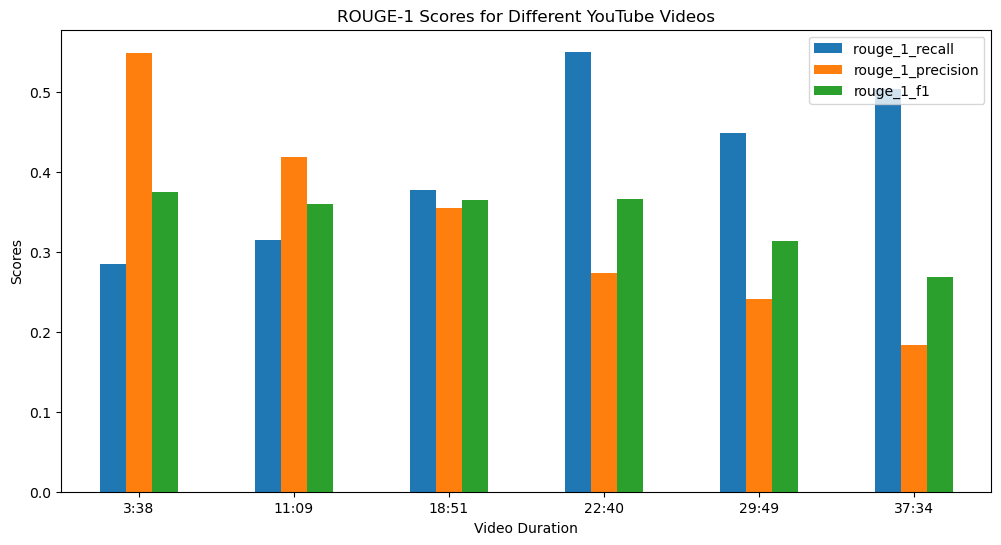

In [5]:
# Plotting
plotdata = pd.DataFrame({"rouge_1_recall ":[0.2847, 0.3155, 0.3770, 0.5505, 0.4485, 0.5040], 
                         "rouge_1_precision":[0.5493, 0.4184, 0.3547, 0.2740,0.2410, 0.1831 ],
                         "rouge_1_f1":[0.3750, 0.3598, 0.3655, 0.3659, 0.3136, 0.2687]},
                        index=["3:38", "11:09", "18:51", "22:40", "29:49", "37:34"])

plotdata.plot(kind="bar", figsize=(12,6))


plt.title('ROUGE-1 Scores for Different YouTube Videos')
plt.xlabel('Video Duration')
plt.ylabel('Scores')
plt.xticks(rotation=0)


plt.show()

##### ROUGE-2 (Recall, Precision, F1-Score)

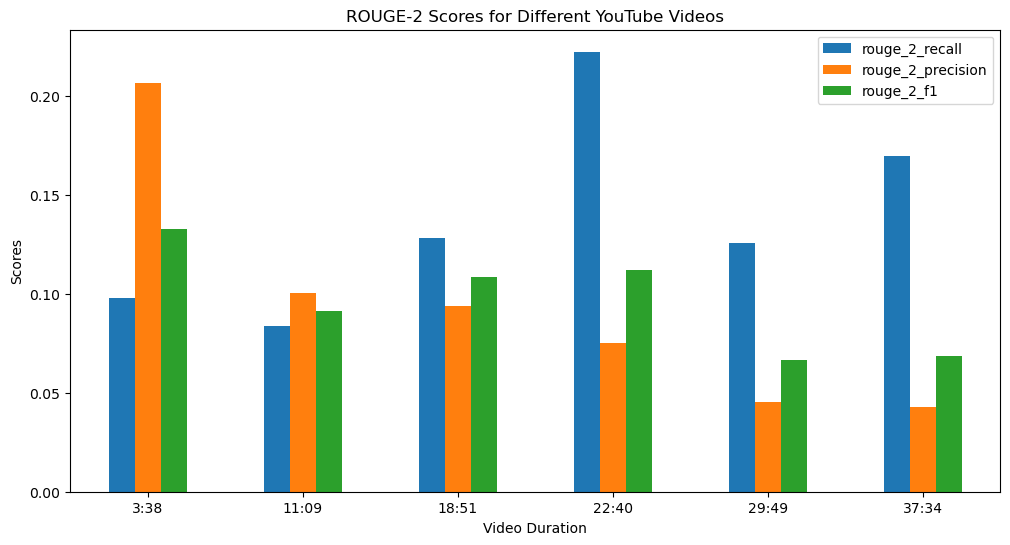

In [6]:
# Plotting
plotdata = pd.DataFrame({"rouge_2_recall":[0.0976, 0.0839, 0.1281, 0.2222, 0.1256, 0.1695], 
                         "rouge_2_precision":[0.2062, 0.1004, 0.0938, 0.0749, 0.0451, 0.0430],
                         "rouge_2_f1":[0.1325, 0.0915, 0.1083, 0.1121, 0.0664, 0.0686]},
                        index=["3:38", "11:09", "18:51", "22:40", "29:49", "37:34"])

plotdata.plot(kind="bar", figsize=(12,6))

# Plot title and labels
plt.title('ROUGE-2 Scores for Different YouTube Videos')
plt.xlabel('Video Duration')
plt.ylabel('Scores')
plt.xticks(rotation=0)

# Show plot
plt.show()

##### ROUGE-L (Recall, Precision, F1-Score)

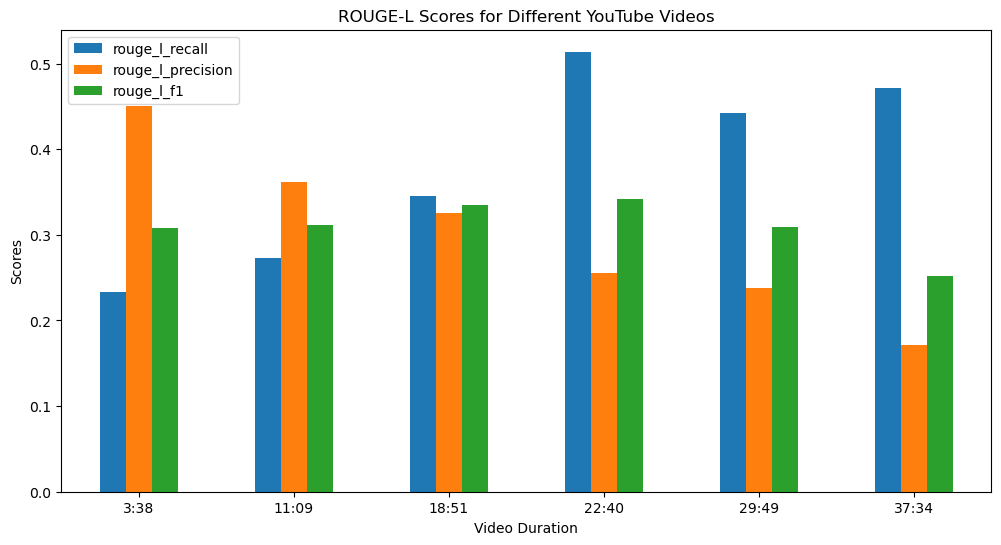

In [7]:
plotdata = pd.DataFrame({"rouge_l_recall":[0.2336, 0.2727, 0.3455, 0.5138, 0.4424, 0.4720], 
                         "rouge_l_precision":[0.4507, 0.3617, 0.3251, 0.2557, 0.2378, 0.1715],
                         "rouge_l_f1":[0.3077, 0.3110, 0.3350, 0.3415, 0.3093, 0.2516]},
                        index=["3:38", "11:09", "18:51", "22:40", "29:49", "37:34"])

plotdata.plot(kind="bar", figsize=(12,6))

# Plot title and labels
plt.title('ROUGE-L Scores for Different YouTube Videos')
plt.xlabel('Video Duration')
plt.ylabel('Scores')
plt.xticks(rotation=0)

# Show plot
plt.show()

Plot corresponds to ROUGE Scores for Different YouTube Videos of different topics.

##### ROUGE-1 (Recall, Precision, F1-score)

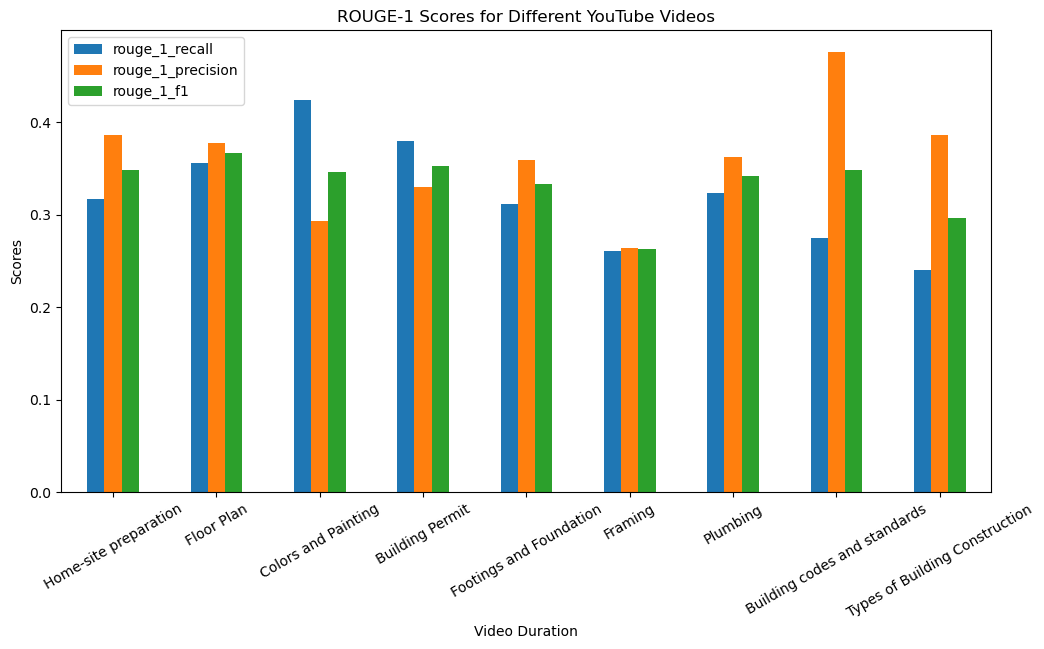

In [8]:
# plotting ROUGE-1
plotdata_rouge_1 = pd.DataFrame({"rouge_1_recall":[0.3165, 0.3563, 0.4235, 0.3793, 0.3111, 0.2609, 0.3231, 0.2746, 0.2407], 
                                 "rouge_1_precision":[0.3860, 0.3780, 0.2927, 0.3300, 0.3590, 0.2642, 0.3621, 0.4756, 0.3861],
                                 "rouge_1_f1":[0.3478, 0.3669, 0.3462, 0.3529, 0.3333, 0.2625, 0.3415, 0.3482, 0.2966]},
                                index=["Home-site preparation", "Floor Plan", "Colors and Painting", "Building Permit", "Footings and Foundation", "Framing", "Plumbing", "Building codes and standards", "Types of Building Construction"])

plotdata_rouge_1.plot(kind="bar", figsize=(12,6))

# Plot title and labels
plt.title('ROUGE-1 Scores for Different YouTube Videos')
plt.xlabel('Video Duration')
plt.ylabel('Scores')
plt.xticks(rotation=30)

# Show plot
plt.show()

##### ROUGE-2 (Recall, Precision, F1-score)

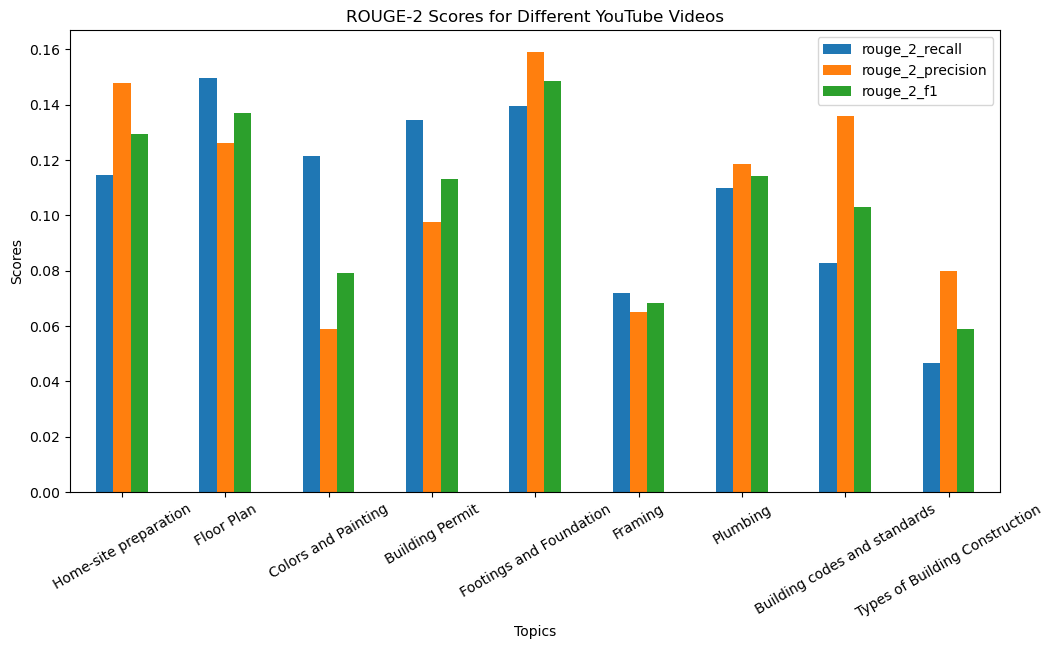

In [9]:
# plotting ROUGE-2
plotdata_rouge_2 = pd.DataFrame({"rouge_2_recall":[0.1147, 0.1495, 0.1215, 0.1345, 0.1393, 0.0720, 0.1099, 0.0829, 0.0465], 
                                 "rouge_2_precision":[0.1479, 0.1260, 0.0588, 0.0976, 0.1589, 0.0651, 0.1186, 0.1360, 0.0800],
                                 "rouge_2_f1":[0.1292, 0.1368, 0.0793, 0.1131, 0.1485, 0.0684, 0.1141, 0.1030, 0.0588]},
                                index=["Home-site preparation", "Floor Plan", "Colors and Painting", "Building Permit", "Footings and Foundation", "Framing", "Plumbing", "Building codes and standards", "Types of Building Construction"])

plotdata_rouge_2.plot(kind="bar", figsize=(12,6))

# Plot title and labels
plt.title('ROUGE-2 Scores for Different YouTube Videos')
plt.xlabel('Topics')
plt.ylabel('Scores')
plt.xticks(rotation=30)

# Show plot
plt.show()

##### ROUGE-L (Recall, Precision, F1-score)

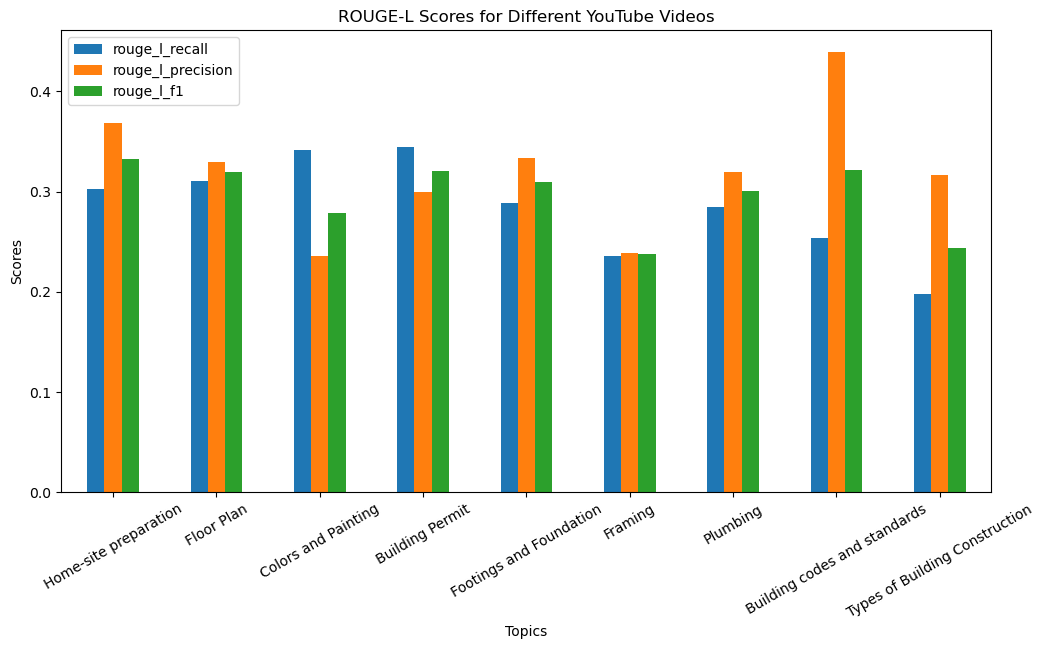

In [11]:
# plotting ROUGE-L
plotdata_rouge_l = pd.DataFrame({"rouge_l_recall":[0.3022, 0.3103, 0.3412, 0.3448, 0.2889, 0.2360, 0.2846, 0.2535, 0.1975], 
                                 "rouge_l_precision":[0.3684, 0.3293, 0.2358, 0.3000, 0.3333, 0.2390, 0.3190, 0.4390, 0.3168],
                                 "rouge_l_f1":[0.3320, 0.3195, 0.2788, 0.3209, 0.3095, 0.2375, 0.3008, 0.3214, 0.2433]},
                                index=["Home-site preparation", "Floor Plan", "Colors and Painting", "Building Permit", "Footings and Foundation", "Framing", "Plumbing", "Building codes and standards", "Types of Building Construction"])

plotdata_rouge_l.plot(kind="bar", figsize=(12,6))

# Plot title and labels
plt.title('ROUGE-L Scores for Different YouTube Videos')
plt.xlabel('Topics')
plt.ylabel('Scores')
plt.xticks(rotation=30)

# Show plot
plt.show()

##### Comparison of ROUGE(Recall, Precision, F1) score against Different Video Duration

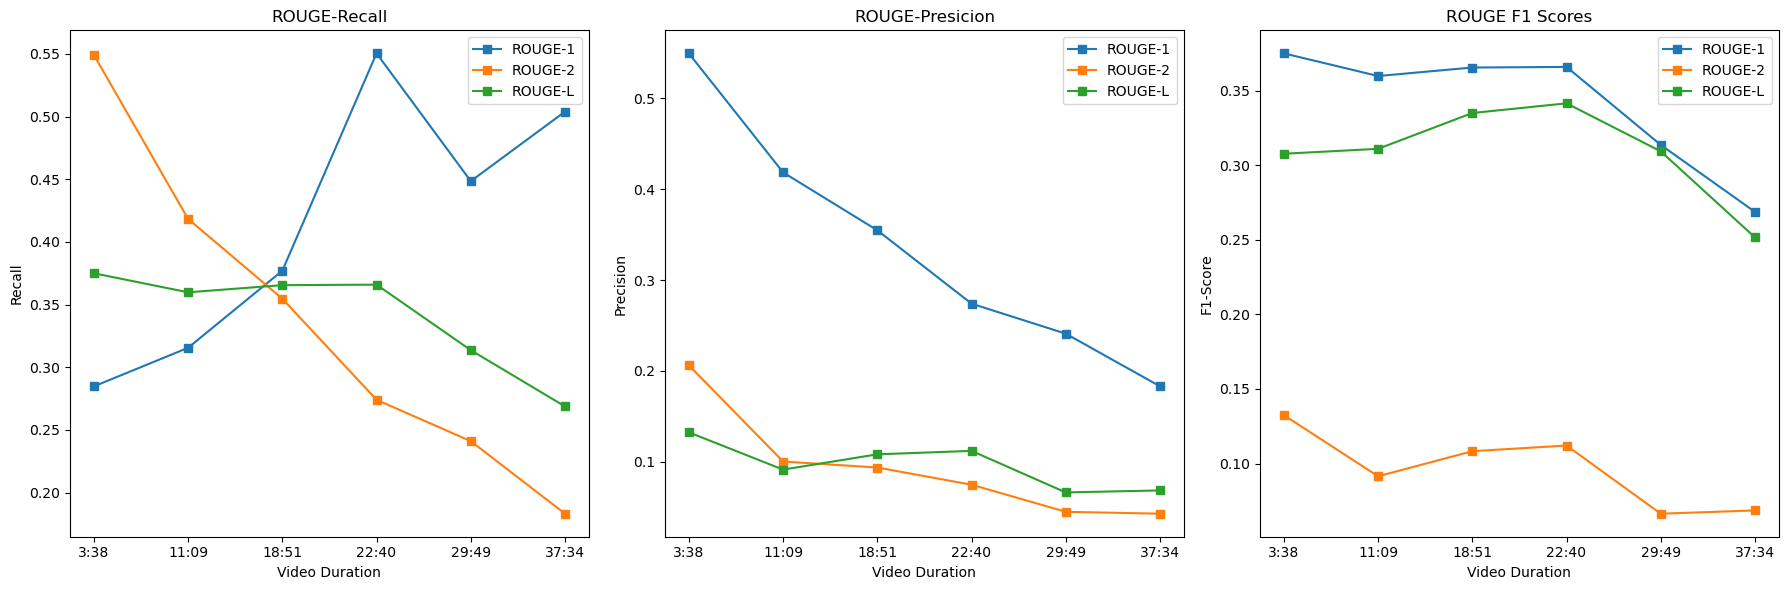

In [13]:
durations = ["3:38", "11:09", "18:51", "22:40", "29:49", "37:34"]


# ROUGE Recall, Precision, F1-Score scores
rouge_1_r = [0.2847, 0.3155, 0.3770, 0.5505, 0.4485, 0.5040]
rouge_2_r = [0.5493, 0.4184, 0.3547, 0.2740, 0.2410, 0.1831]
rouge_l_r = [0.3750, 0.3598, 0.3655, 0.3659, 0.3136, 0.2687]

rouge_1_p = [0.5493, 0.4184, 0.3547, 0.2740,0.2410, 0.1831 ]
rouge_2_p = [0.2062, 0.1004, 0.0938, 0.0749, 0.0451, 0.0430]
rouge_l_p = [0.1325, 0.0915, 0.1083, 0.1121, 0.0664, 0.0686]

rouge_1_f1 = [0.3750, 0.3598, 0.3655, 0.3659, 0.3136, 0.2687]
rouge_2_f1 = [0.1325, 0.0915, 0.1083, 0.1121, 0.0664, 0.0686]
rouge_l_f1 = [0.3077, 0.3110, 0.3350, 0.3415, 0.3093, 0.2516]

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot ROUGE Recall 
axs[0].plot(durations, rouge_1_r, marker='s', label='ROUGE-1')
axs[0].plot(durations, rouge_2_r, marker='s', label='ROUGE-2')
axs[0].plot(durations, rouge_l_r, marker='s', label='ROUGE-L')
axs[0].set_title('ROUGE-Recall')
axs[0].set_xlabel('Video Duration')
axs[0].set_ylabel('Recall')
axs[0].legend(loc='upper right')
axs[0].tick_params(axis='x', rotation=0)

# Plot ROUGE Precision 
axs[1].plot(durations, rouge_1_p, marker='s', label='ROUGE-1')
axs[1].plot(durations, rouge_2_p, marker='s', label='ROUGE-2')
axs[1].plot(durations, rouge_l_p, marker='s', label='ROUGE-L')
axs[1].set_title('ROUGE-Presicion')
axs[1].set_xlabel('Video Duration')
axs[1].set_ylabel('Precision')
axs[1].legend(loc='upper right')
axs[1].tick_params(axis='x', rotation=0)

# Plot ROUGE F1-Score 
axs[2].plot(durations, rouge_1_f1, marker='s', label='ROUGE-1')
axs[2].plot(durations, rouge_2_f1, marker='s', label='ROUGE-2')
axs[2].plot(durations, rouge_l_f1, marker='s', label='ROUGE-L')
axs[2].set_title('ROUGE F1 Scores')
axs[2].set_xlabel('Video Duration')
axs[2].set_ylabel('F1-Score')
axs[2].legend(loc='upper right')
axs[2].tick_params(axis='x', rotation=0)


plt.tight_layout()
plt.show()

##### Comparison of ROUGE(Recall, Precision, F1) score against Different Video Topics

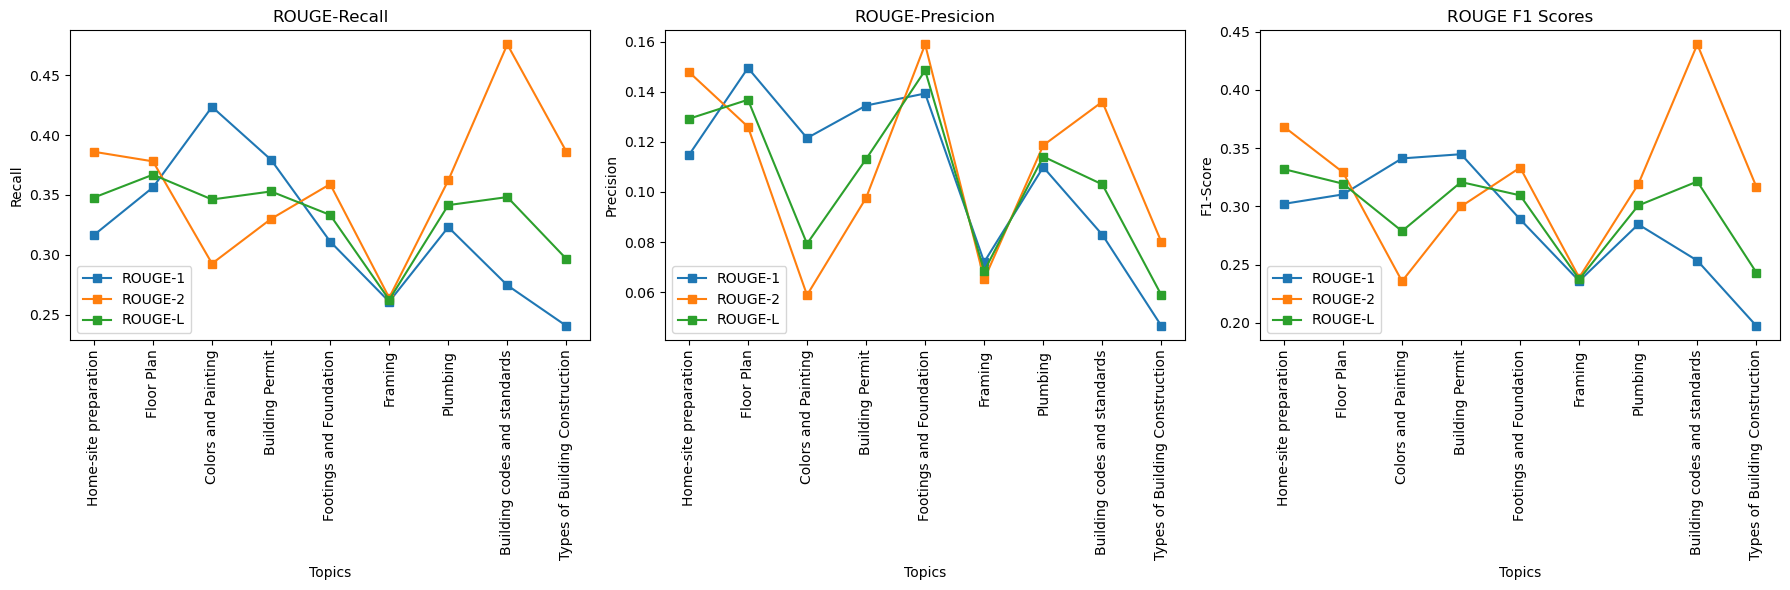

In [17]:
topics = ["Home-site preparation", "Floor Plan", "Colors and Painting", "Building Permit", "Footings and Foundation", "Framing", "Plumbing", "Building codes and standards", "Types of Building Construction"]

# ROUGE Recall, Precision, F1-Score scores
rouge_1_r = [0.3165, 0.3563, 0.4235, 0.3793, 0.3111, 0.2609, 0.3231, 0.2746, 0.2407]
rouge_2_r = [0.3860, 0.3780, 0.2927, 0.3300, 0.3590, 0.2642, 0.3621, 0.4756, 0.3861]
rouge_l_r = [0.3478, 0.3669, 0.3462, 0.3529, 0.3333, 0.2625, 0.3415, 0.3482, 0.2966]

rouge_1_p = [0.1147, 0.1495, 0.1215, 0.1345, 0.1393, 0.0720, 0.1099, 0.0829, 0.0465]
rouge_2_p = [0.1479, 0.1260, 0.0588, 0.0976, 0.1589, 0.0651, 0.1186, 0.1360, 0.0800]
rouge_l_p = [0.1292, 0.1368, 0.0793, 0.1131, 0.1485, 0.0684, 0.1141, 0.1030, 0.0588]

rouge_1_f1 = [0.3022, 0.3103, 0.3412, 0.3448, 0.2889, 0.2360, 0.2846, 0.2535, 0.1975]
rouge_2_f1 = [0.3684, 0.3293, 0.2358, 0.3000, 0.3333, 0.2390, 0.3190, 0.4390, 0.3168]
rouge_l_f1 = [0.3320, 0.3195, 0.2788, 0.3209, 0.3095, 0.2375, 0.3008, 0.3214, 0.2433]

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot ROUGE Recall 
axs[0].plot(topics, rouge_1_r, marker='s', label='ROUGE-1')
axs[0].plot(topics, rouge_2_r, marker='s', label='ROUGE-2')
axs[0].plot(topics, rouge_l_r, marker='s', label='ROUGE-L')
axs[0].set_title('ROUGE-Recall')
axs[0].set_xlabel('Topics')
axs[0].set_ylabel('Recall')
axs[0].legend(loc='lower left')
axs[0].tick_params(axis='x', rotation=90)

# Plot ROUGE Precision 
axs[1].plot(topics, rouge_1_p, marker='s', label='ROUGE-1')
axs[1].plot(topics, rouge_2_p, marker='s', label='ROUGE-2')
axs[1].plot(topics, rouge_l_p, marker='s', label='ROUGE-L')
axs[1].set_title('ROUGE-Presicion')
axs[1].set_xlabel('Topics')
axs[1].set_ylabel('Precision')
axs[1].legend(loc='lower left')
axs[1].tick_params(axis='x', rotation=90)

# Plot ROUGE F1-Score 
axs[2].plot(topics, rouge_1_f1, marker='s', label='ROUGE-1')
axs[2].plot(topics, rouge_2_f1, marker='s', label='ROUGE-2')
axs[2].plot(topics, rouge_l_f1, marker='s', label='ROUGE-L')
axs[2].set_title('ROUGE F1 Scores')
axs[2].set_xlabel('Topics')
axs[2].set_ylabel('F1-Score')
axs[2].legend(loc='lower left')
axs[2].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()